In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries 


import pandas as pd


from tqdm.notebook import tqdm
from tqdm.autonotebook import trange
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
import time


import sklearn
from sklearn.preprocessing import StandardScaler

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style type='text/css'>.CodeMirror{font-size: 16px;</style>"))


['1999-11-01', '1999-11-02', '1999-11-03', '1999-11-04', '1999-11-05', '1999-11-08', '1999-11-09', '1999-11-10', '1999-11-11', '1999-11-12', '1999-11-15', '1999-11-16', '1999-11-17', '1999-11-18', '1999-11-19', '1999-11-22', '1999-11-23', '1999-11-24', '1999-11-26', '1999-11-29', '1999-11-30', '1999-12-01', '1999-12-02', '1999-12-03', '1999-12-06', '1999-12-07', '1999-12-08', '1999-12-09', '1999-12-10', '1999-12-13', '1999-12-14', '1999-12-15', '1999-12-16', '1999-12-17', '1999-12-20', '1999-12-21', '1999-12-22', '1999-12-23', '1999-12-27', '1999-12-28', '1999-12-29', '1999-12-30', '1999-12-31', '2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14', '2000-01-18', '2000-01-19', '2000-01-20', '2000-01-21', '2000-01-24', '2000-01-25', '2000-01-26', '2000-01-27', '2000-01-28', '2000-01-31', '2000-02-01', '2000-02-02', '2000-02-03', '2000-02-04', '2000-02-07', '2000-02-08', '2000-02-09', '2000-02-10', '2000

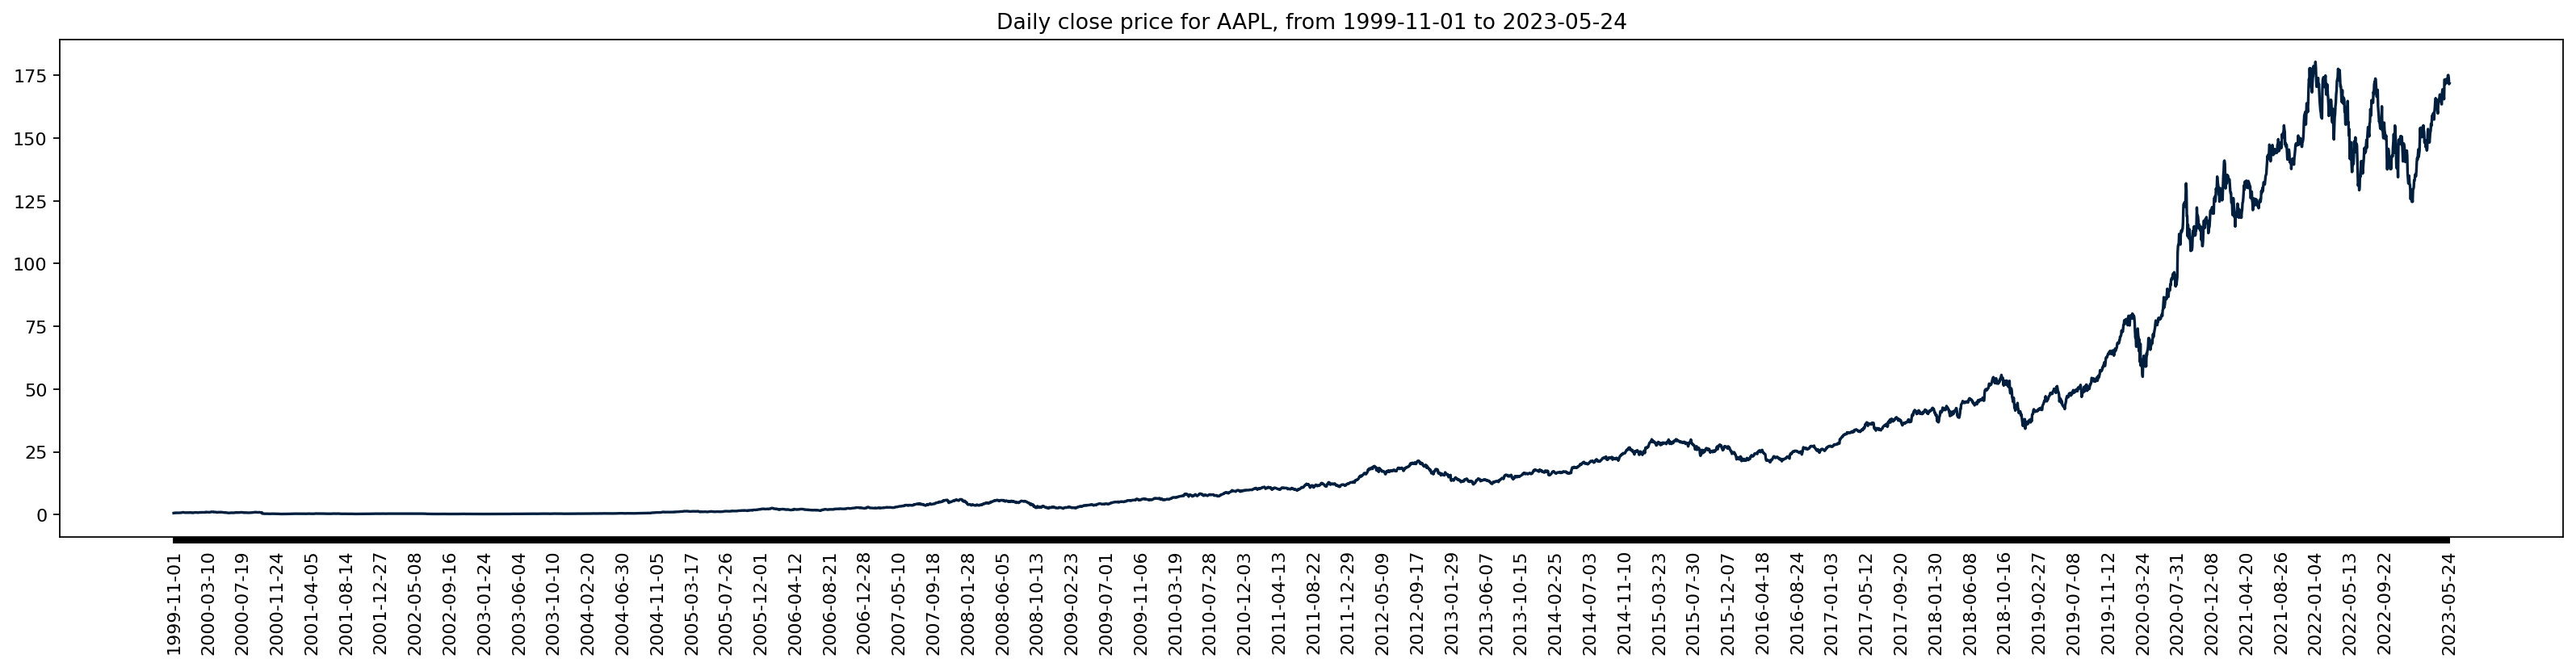

In [8]:





config = {
    "alpha_vantage": {
        "key": "JS1SVUP23PNY92G7", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
        "symbol": "AAPL",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}





def download_data(config, plot=False):
    # get the data from alpha vantage

    ts = TimeSeries(key=config["alpha_vantage"]["key"])
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()
    #print(data_date)
    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = plt.figure(figsize=(25, 5), dpi=160)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0,len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
        plt.show()

    return data_date, data_close_price, num_data_points, display_date_range, data

data_date, data_close_price, num_data_points, display_date_range, data = download_data(config, plot=config["plots"]["show_plots"])



In [15]:
print(type(data), type(data_date), type(data_close_price), type(num_data_points), type(display_date_range))


<class 'dict'> <class 'list'> <class 'numpy.ndarray'> <class 'int'> <class 'str'>


In [14]:
print(dates[1])

2023-05-23
